In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use('science')
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data 

In [3]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

## Optimization Model 

In [4]:
# model for shortest path
sp_model = pyepo.model.omo.shortestPathModel(grid, solver='gurobi')
#sp_model = pyepo.model.omo.shortestPathModel(grid, solver='glpk')

Solver in the background: gurobi


In [5]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 5)
(5, 10)
(10, 15)
(15, 20)
(20, 21)
(21, 22)
(22, 23)
(23, 24)


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.44it/s]


In [9]:
# get test data set
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 246.80it/s]


In [10]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [12]:
x.shape

torch.Size([32, 5])

In [13]:
c.shape

torch.Size([32, 40])

In [14]:
w.shape

torch.Size([32, 40])

In [15]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [18]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [19]:
# training
twostage_model.fit(sp_dataset_train.feats, sp_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [20]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.feats)

In [21]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.costs[i]
    z_true_i = sp_dataset_test.objs[i,0]
    truespo += pyepo.eval.calTrueSPO(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.eval.calUnambSPO(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(sp_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(sp_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.11it/s]


Normalized true SPO Loss: 1.61%
Normalized unambiguous SPO Loss: 1.61%


In [22]:
# compare solutions
for i, data in enumerate(sp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.28, 0.16, 0.55, -0.67, 0.99, -0.21, -0.41, 0.30, -0.19, 0.41, -0.21, 0.04, -0.57, 0.30, -0.33, 0.30, -0.84, 0.20, 0.05, -0.21, 0.04, 0.20, 0.57, -0.09, 0.79, -0.41, -0.33, -0.33, 0.46, 0.55, 0.33, -0.57, 0.33, 0.16, 0.55, 0.55, -0.41, 0.55, -0.05, 0.20
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10

## Linear Regression from PyTorch

In [23]:
from torch import nn

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [25]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [27]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [28]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   3.9595, True SPO Loss: 21.5262%, Unambiguous SPO Loss: 21.5263%
Epoch  20, Loss:   3.9775, True SPO Loss: 10.1939%, Unambiguous SPO Loss: 10.1939%
Epoch  30, Loss:   0.3923, True SPO Loss:  4.7226%, Unambiguous SPO Loss:  4.7226%
Epoch  40, Loss:   0.9000, True SPO Loss:  2.9677%, Unambiguous SPO Loss:  2.9677%
Epoch  50, Loss:   0.4126, True SPO Loss:  2.1921%, Unambiguous SPO Loss:  2.1922%
Epoch  60, Loss:   0.0652, True SPO Loss:  1.4654%, Unambiguous SPO Loss:  1.4654%
Epoch  70, Loss:   0.3336, True SPO Loss:  1.1084%, Unambiguous SPO Loss:  1.1084%
Epoch  80, Loss:   0.4613, True SPO Loss:  0.9627%, Unambiguous SPO Loss:  0.9627%
Epoch  90, Loss:   0.1272, True SPO Loss:  0.8433%, Unambiguous SPO Loss:  0.8433%
Epoch 100, Loss:   0.0158, True SPO Loss:  0.7246%, Unambiguous SPO Loss:  0.7246%
Epoch 110, Loss:   0.0534, True SPO Loss:  0.6147%, Unambiguous SPO Loss:  0.6147%
Epoch 120, Loss:   0.0358, True SPO Loss:  0.6246%, Unambiguous SPO Loss:  0.6246%
Epoc

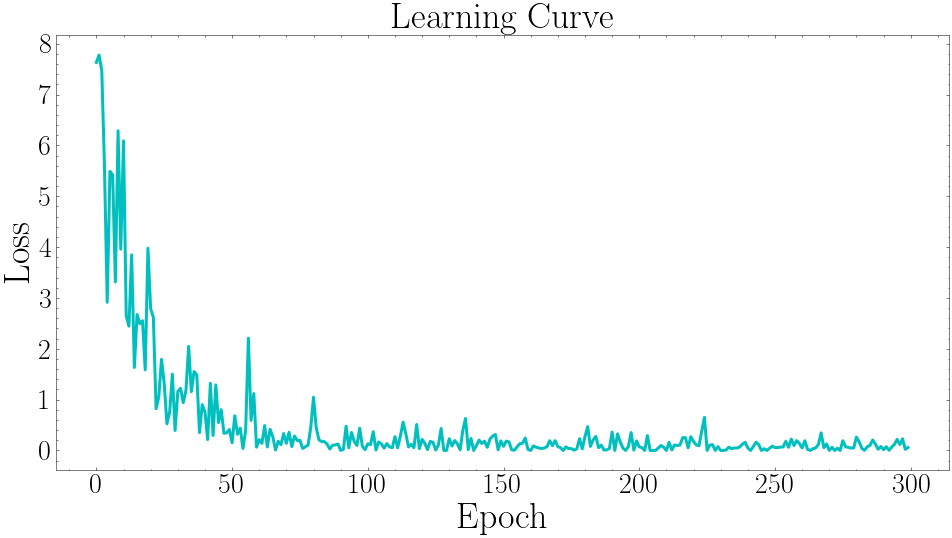

In [29]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color='c', lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.show()

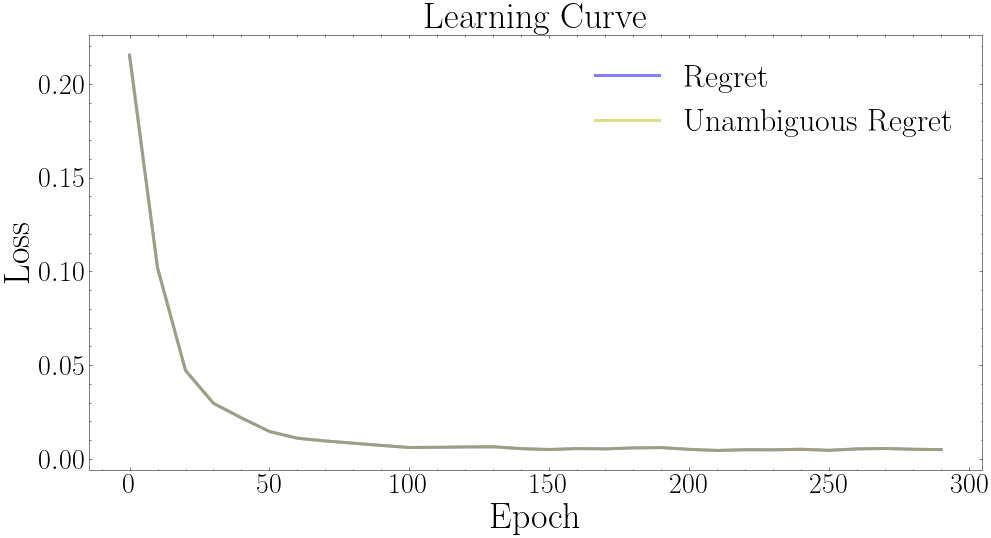

In [30]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=3, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=3, label='Unambiguous Regret')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [31]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.50%
Normalized unambiguous SPO Loss: 0.50%


In [32]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -0.91, -0.07, 0.55, 0.49, 0.94, -0.21, -0.15, -0.47, -0.38, 0.81, -0.74, -0.76, 0.17, 0.59, -0.14, 1.11, -1.10, -0.96, 0.54, -0.24, -1.03, -0.18, -0.21, 0.06, -0.37, -0.19, 0.15, 0.36, -0.37, 1.55, 0.02, -0.89, -0.34, -0.75, 0.37, -0.41, 0.02, -0.27, 0.73, -0.61
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.38

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.

## Black-Box

In [33]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [34]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-4)

In [35]:
# set loss
criterion = nn.L1Loss()
bb = pyepo.func.blackboxOpt(sp_model, lambd=10, processes=4)

Num of cores: 4


In [36]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   0.5783, True SPO Loss: 22.8213%, Unambiguous SPO Loss: 22.8213%
Epoch  20, Loss:   0.5612, True SPO Loss: 14.4308%, Unambiguous SPO Loss: 14.4308%
Epoch  30, Loss:   0.9673, True SPO Loss:  9.4767%, Unambiguous SPO Loss:  9.4767%
Epoch  40, Loss:   0.1839, True SPO Loss:  7.0805%, Unambiguous SPO Loss:  7.0805%
Epoch  50, Loss:   0.3624, True SPO Loss:  6.3821%, Unambiguous SPO Loss:  6.3821%
Epoch  60, Loss:   0.1573, True SPO Loss:  5.7322%, Unambiguous SPO Loss:  5.7322%
Epoch  70, Loss:   0.1312, True SPO Loss:  5.4754%, Unambiguous SPO Loss:  5.4754%
Epoch  80, Loss:   0.1459, True SPO Loss:  5.1247%, Unambiguous SPO Loss:  5.1248%
Epoch  90, Loss:   0.2443, True SPO Loss:  4.8753%, Unambiguous SPO Loss:  4.8753%
Epoch 100, Loss:   0.1948, True SPO Loss:  5.5845%, Unambiguous SPO Loss:  5.5846%
Epoch 110, Loss:   0.4563, True SPO Loss:  5.5494%, Unambiguous SPO Loss:  5.5496%
Epoch 120, Loss:   0.1976, True SPO Loss:  6.9523%, Unambiguous SPO Loss:  6.9528%
Epoc

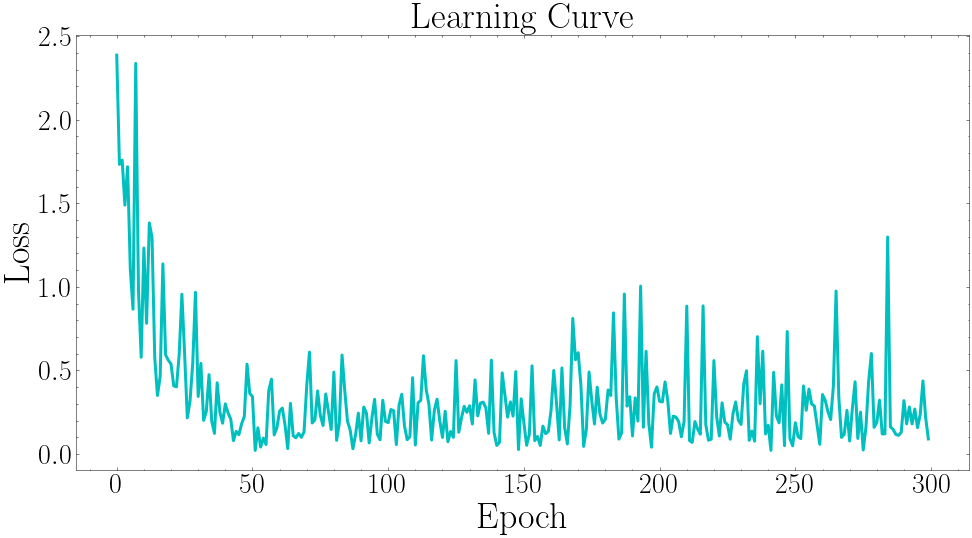

In [37]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color='c', lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.show()

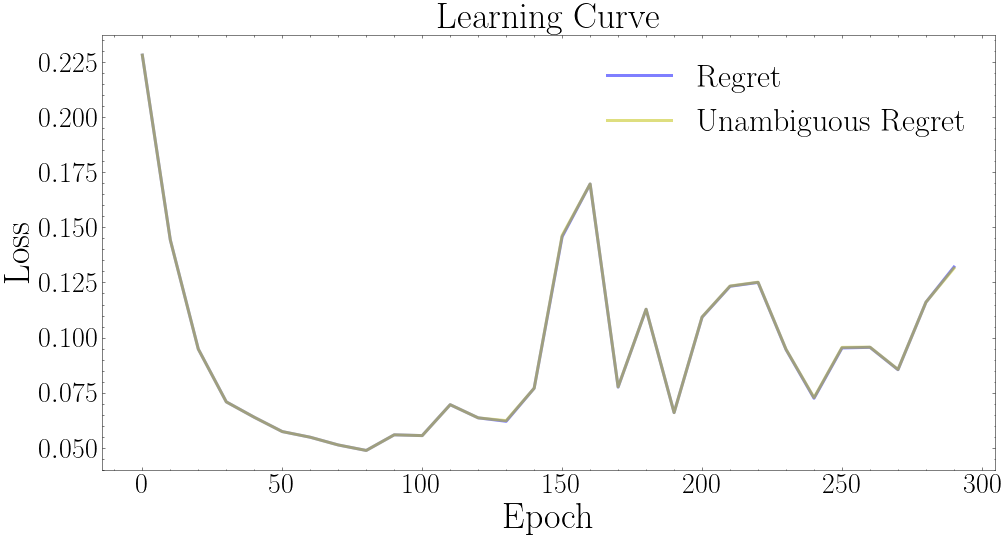

In [38]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=3, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=3, label='Unambiguous Regret')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [39]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 13.20%
Normalized unambiguous SPO Loss: 13.15%


In [40]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.51, -0.75, 1.19, -1.00, -0.86, -0.81, 0.18, 0.48, 1.37, 0.57, -0.18, 0.57, -1.66, 0.14, -0.47, -0.42, -0.88, 0.60, -0.04, -0.14, 0.13, 0.40, 0.59, -0.20, -0.50, 0.01, -0.00, -0.41, -0.44, 0.65, -0.29, -0.32, -0.36, -0.53, -0.97, -0.58, 1.08, -0.54, 0.12, 0.10
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 1.46

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.1